In [23]:
import webbrowser
webbrowser.open_new_tab(url)

In [ ]:
from tensorflow.keras.models import load_model
import nibabel as nib
from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Define constants
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = True
SLICE_Y = True
SLICE_Z = False

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [3]:
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [4]:
targetName = 'tooth5'
targetImagePath = f'data/volumes/img/{targetName}.nii'
targetMaskPath  = f'data/volumes/mask/{targetName}.nii'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
imgMask = imgMaskNii.get_fdata()

In [5]:
model = load_model('UNET-ToothSegmentation_40_80.h5')

## Single slicing prediction

In [6]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [7]:
sliceIndex = 24

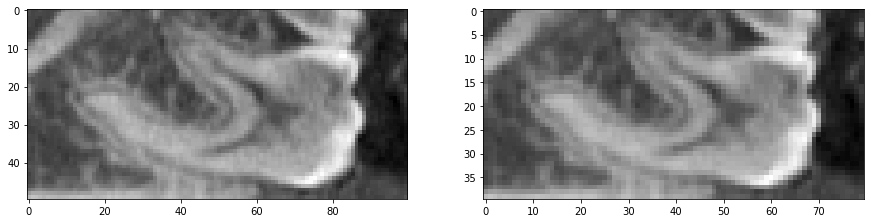

((50, 100), (40, 80))

In [8]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[sliceIndex,:,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

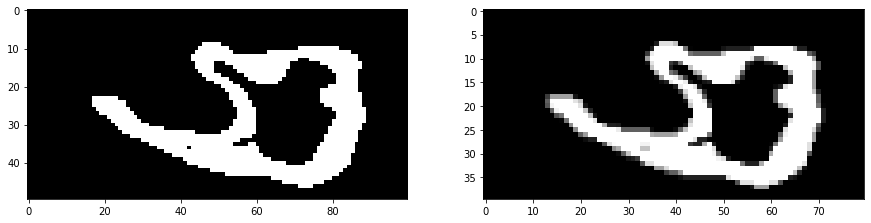

((50, 100), (40, 80))

In [9]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[sliceIndex,:,:]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

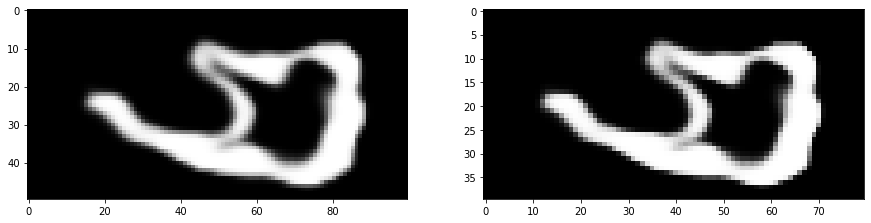

((50, 100), (40, 80))

In [10]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

## Predicting a full volume

In [11]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [12]:
predImg = predictVolume(imgTarget)

In [13]:
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=24, continuous_update=False, description='x', max=49), IntSlider(value=2…

In [14]:
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(predImg))
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=24, continuous_update=False, description='x', max=49), IntSlider(value=2…

In [15]:
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=24, continuous_update=False, description='x', max=49), IntSlider(value=2…

## Convert binary image to mesh

In [16]:
from skimage.measure import marching_cubes_lewiner

In [17]:
vertices,faces,_,_ = marching_cubes_lewiner(predImg)

In [18]:
import meshplot as mp

In [19]:
mp.plot(vertices, faces, return_plot=False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(27.25, 24…

## Save mesh to file (.stl)

In [20]:
from stl import mesh

In [21]:
def dataToMesh(vert, faces):
    mm = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            mm.vectors[i][j] = vert[f[j],:]
    return mm

In [22]:
mm = dataToMesh(vertices, faces)
mm.save('tooth-segmented.stl')

In [ ]:
# https://github.com/madsendennis/notebooks